# Pitch F/X Analysis
_The data processed in this notebook is huge. It is strongly recommended that you don't run the full notebook locally. Only the first two cells must be run for the scripts to process the data. The format is designed to be modular between headings._

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import fbprophet as prophet
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# 2018 Pitch F/X Dataset

In [3]:
df = pd.read_csv('pitches_cleaner.csv',na_values=[float('nan')])
df.head()

Unnamed: 0         ax         ay         az  break_angle  break_length  \
0         0.0 -19.911162  32.791492 -17.557766         43.7           5.8   
1         1.0 -20.043108  30.911711 -18.780096         42.7           6.1   
2         2.0 -21.510485  30.321994 -18.731107         44.4           6.0   
3         3.0   4.974062  21.571764 -38.346692         -8.2          10.8   
4         4.0 -20.172978  30.364878 -21.028992         40.9           6.1   

   break_y  cc code              des  ...       vz0       x        x0       y  \
0     23.7 NaN    C    Called Strike  ... -7.015046  107.87 -0.869064  188.86   
1     23.8 NaN    B             Ball  ... -9.145946  147.65 -0.942066  213.84   
2     23.8 NaN    C    Called Strike  ... -7.507958   94.10 -0.705522  195.28   
3     23.9 NaN    F             Foul  ... -2.125677   61.60 -0.732282  199.22   
4     23.8 NaN    S  Swinging Strike  ... -5.049660  133.31 -0.802268  171.57   

     y0        z0  zone on_1b on_3b  on_2b  
0  50.0  5.696240   9.0   NaN   NaN    NaN  
1  50.0  5.617264  13.0   NaN   NaN    NaN  
2  50.0  5.646685   9.0   NaN   NaN    NaN  
3  50.0  5.768441  14.0   NaN   NaN    NaN  
4  50.0  5.726734   4.0   NaN   NaN    NaN  

[5 rows x 43 columns]

# Data Field Defs

__des__: a brief text description of the result of the pitch: Ball; Ball In Dirt; Called Strike; Foul; Foul (Runner Going); Foul Tip; Hit by Pitch; In play, no out; In 

**play, out(s)**; In play, run(s); Intent Ball; Pitchout; Swinging Strike; Swinging Strike (Blocked).

**id**: a unique identification number per pitch within a game. The numbers increment by one for each pitch but are not consecutive between at bats.

**type**: a one-letter abbreviation for the result of the pitch: B, ball; S, strike (including fouls); X, in play.

**x, y**: the horizontal and vertical location of the pitch as it crossed home plate as input by the Gameday stringer using the old Gameday coordinate system. I’m not sure what units are used or where the origin is located. Note that the y dimension in the old coordinate system is now called the z dimension in the new PITCHf/x coordinate system detailed below.

**start_speed**: the pitch speed, in miles per hour and in three dimensions, measured at the initial point, y0. Of the two speeds, this one is closer to the speed measured by a radar gun and what we are familiar with for a pitcher’s “velocity” .

**end_speed**: the pitch speed measured as it crossed the front of home plate.

**sz_top**: the distance in feet from the ground to the top of the current batter’s rulebook strike zone as measured from the video by the PITCHf/x operator. The operator sets a line at the batter’s belt as he settles into the hitting position, and the PITCHf/x software adds four inches up for the top of the zone.

**sz_bot**: the distance in feet from the ground to the bottom of the current batter’s rulebook strike zone. The PITCHf/x operator sets a line at the hollow of the knee for the bottom of the zone.

**pfx_x**: the horizontal movement, in inches, of the pitch between the release point and home plate, as compared to a theoretical pitch thrown at the same speed with no spin-induced movement. This parameter is measured at y=40 feet regardless of the y0 value.

**pfx_z**: the vertical movement, in inches, of the pitch between the release point and home plate, as comparbed to a theoretical pitch thrown at the same speed with no spin-induced movement. This parameter is measured at y=40 feet regardless of the y0 value.

**px**: the left/right distance, in feet, of the pitch from the middle of the plate as it crossed home plate. The PITCHf/x coordinate system is oriented to the catcher’s/umpire’s perspective, with distances to the right being positive and to the left being negative.

**pz**: the height of the pitch in feet as it crossed the front of home plate.

**x0**: the left/right distance, in feet, of the pitch, measured at the initial point.

**y0**: the distance in feet from home plate where the PITCHf/x system is set to measure the initial parameters. This parameter has been variously set at 40, 50, or 55 feet (and in a few instances 45 feet) from the plate at different times throughout the 2007 season as Sportvision experiments with optimal settings for the PITCHf/x measurements. Sportvision settled on 50 feet in the second half of 2007, and this value of y0=50 feet has been used since. Changes in this parameter impact the values of all other parameters measured at the release point, such as start_speed.

**z0**: the height, in feet, of the pitch, measured at the initial point.

**vx0, vy0, vz0**: the velocity of the pitch, in feet per second, in three dimensions, measured at the initial point.

**ax, ay, az**: the acceleration of the pitch, in feet per second per second, in three dimensions, measured at the initial point.

**break_y**: the distance in feet from home plate to the point in the pitch trajectory where the pitch achieved its greatest deviation from the straight line path between the release point and the front of home plate.

**break_angle**: the angle, in degrees, from vertical to the straight line path from the release point to where the pitch crossed the front of home plate, as seen from the catcher’s/umpire’s perspective.

**break_length**: the measurement of the greatest distance, in inches, between the trajectory of the pitch at any point between the release point and the front of home plate, and the straight line path from the release point and the front of home plate, per the MLB Gameday team. John Walsh’s article “In Search of the Sinker” has a good illustration of this parameter.

In [124]:
df.columns

Index(['Unnamed: 0', 'ax', 'ay', 'az', 'break_angle', 'break_length',
       'break_y', 'cc', 'code', 'des', 'end_speed', 'event_num', 'id', 'mt',
       'nasty', 'pfx_x', 'pfx_z', 'pitch_type', 'play_guid', 'px', 'pz',
       'spin_dir', 'spin_rate', 'start_speed', 'sv_id', 'sz_bot', 'sz_top',
       'tfs', 'tfs_zulu', 'type', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x',
       'x0', 'y', 'y0', 'z0', 'zone', 'on_1b', 'on_3b', 'on_2b'],
      dtype='object')

# Visualizing Data

## Acceleration 

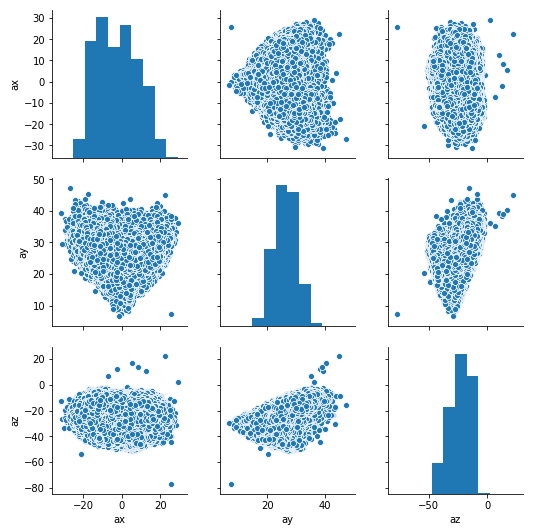

In [100]:
accele = df[['ax','ay','az']]
sns.pairplot(accele.dropna())
plt.show()

* heart shape pattern in ax ay relationship
* triangular pattern in ay az relationship

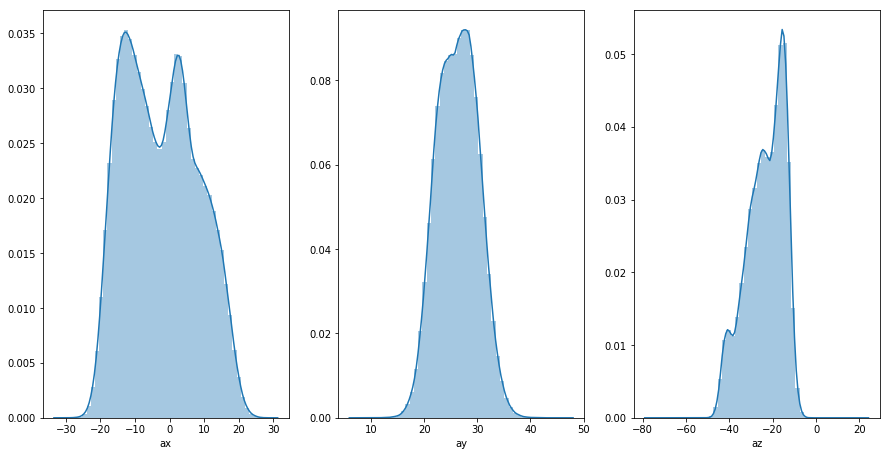

In [40]:
f, axes = plt.subplots(1, 3, figsize=(15, 7.5))
sns.distplot(df['ax'].dropna(),ax=axes[0])
sns.distplot(df['ay'].dropna(),ax=axes[1])
sns.distplot(df['az'].dropna(),ax=axes[2])
plt.show()

- the humps in the ax 
- the staggering pattern we see in the az

In [37]:
pd.concat([df['ax'].describe(),df['ay'].describe(),df['az'].describe()],axis=1)

ax             ay             az
count  727329.000000  727329.000000  727329.000000
mean       -2.449146      26.257701     -23.415771
std        10.511827       3.836128       8.664494
min       -31.250107       6.647863     -77.171421
25%       -11.469332      23.381854     -29.418998
50%        -2.902223      26.299816     -22.244187
75%         5.607917      29.054002     -16.194015
max        29.083263      47.216508      22.305201

## Velocity 

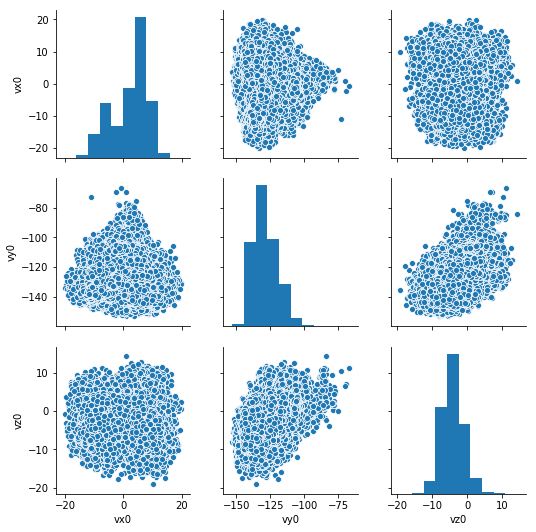

In [102]:
vel = df[['vx0','vy0','vz0']]
sns.pairplot(vel.dropna())
plt.show()

- we see the heart in the ax and ay but we dont see that triangular pattern in the ay az relationship anymore

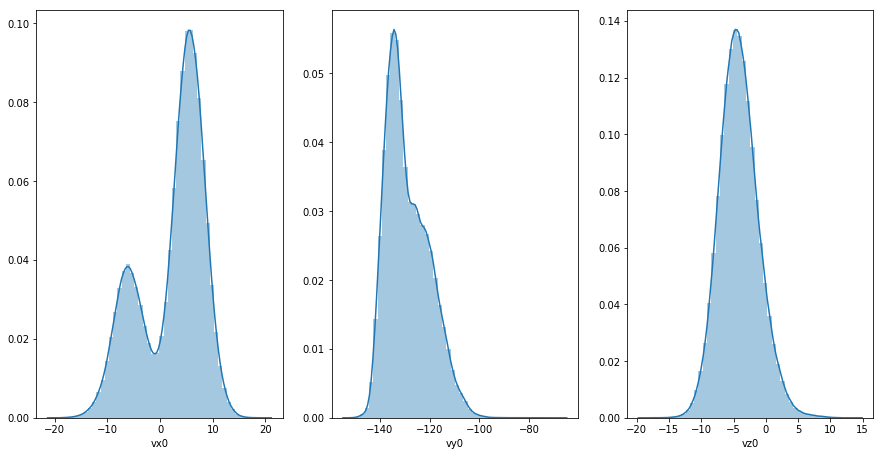

In [103]:
f, axes = plt.subplots(1, 3, figsize=(15, 7.5))
sns.distplot(df['vx0'].dropna(),ax=axes[0])
sns.distplot(df['vy0'].dropna(),ax=axes[1])
sns.distplot(df['vz0'].dropna(),ax=axes[2])
plt.show()

- the ax holds the same pattern in both the acceleration but the ay and az are seemingly flipped - need to check

In [101]:
pd.concat([df['vx0'].describe(),df['vy0'].describe(),df['vz0'].describe()],axis=1)

vx0            vy0            vz0
count  727329.000000  727329.000000  727329.000000
mean        2.299529    -128.837902      -4.136934
std         6.072189       8.589939       3.060756
min       -20.095413    -152.936501     -19.110105
25%        -2.729157    -135.446929      -6.210879
50%         4.150164    -130.678955      -4.297785
75%         6.761978    -122.808973      -2.240930
max        19.837779     -66.852415      14.284177

## Release Positon

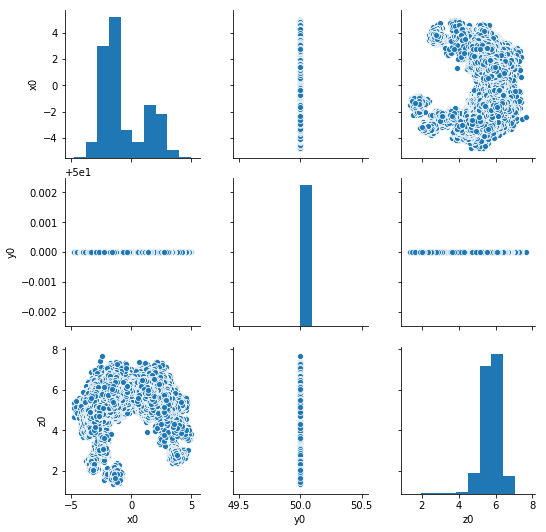

In [114]:
init_pos = df[['x0','y0','z0']]
sns.pairplot(init_pos.dropna())
plt.show()

- clamshell pattern in the release points

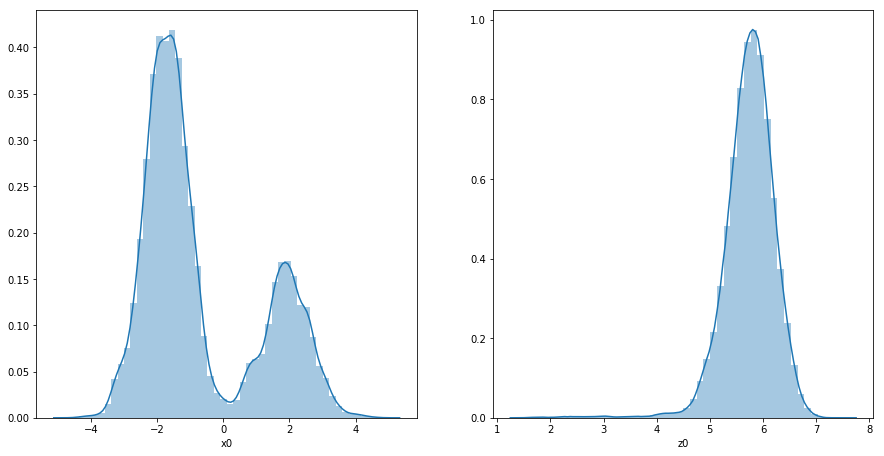

In [117]:
f, axes = plt.subplots(1, 2, figsize=(15, 7.5))
sns.distplot(df['x0'].dropna(),ax=axes[0])
sns.distplot(df['z0'].dropna(),ax=axes[1])
plt.show()

## Homeplate Cross Position

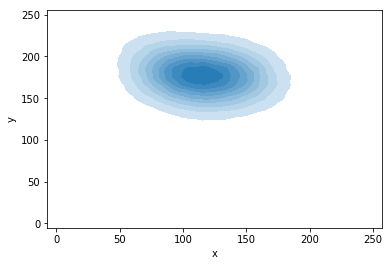

In [130]:
sns.kdeplot(df['x'].dropna(),df['y'].dropna(),shade=True,shade_lowest=False)
plt.show()

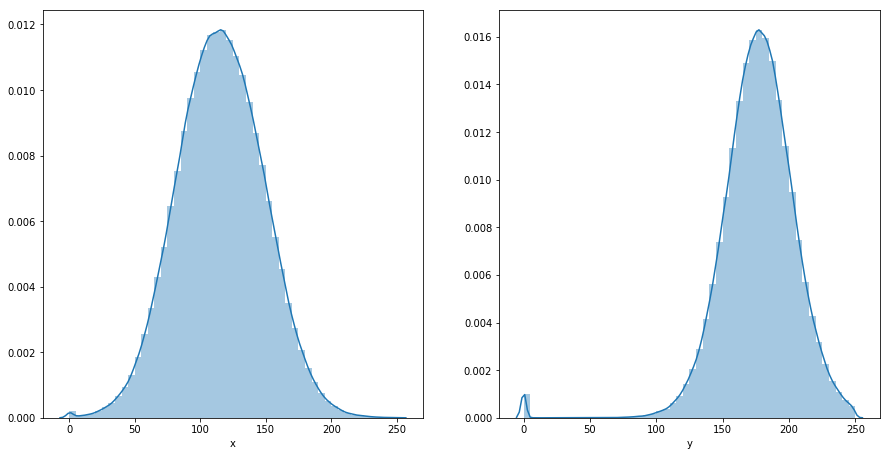

In [36]:
f, axes = plt.subplots(1, 2, figsize=(15, 7.5))
sns.distplot(df['x'],ax=axes[0])
sns.distplot(df['y'],ax=axes[1])
plt.show()

- very nice normal dist for box positioning - might be useful later in the project 

In [33]:
pd.concat([df['x'].describe(),df['y'].describe()],axis=1)

x              y
count  728406.000000  728406.000000
mean      115.454914     176.691426
std        32.918343      27.988268
min         0.000000       0.000000
25%        92.950000     160.900000
50%       115.280000     177.500000
75%       137.970000     194.070000
max       249.930000     250.000000

## Start and End Speeds 

In [88]:
pitch_types = [('Changeup (CH)','CH'),
('Curveball (CU)','CU'),
('Cutter (FC)','FC'),
('Eephus (EP)','EP'),
('Forkball (FO)','FO'),
('Four-Seam Fastball (FA)','FA'),
('Knuckleball (KN)','KN'),
('Knuckle-curve (KC)','KC'),
('Screwball (SC)','SC'),
('Sinker (SI)','SI'), 
('Slider (SL)','SL'),
('Splitter (FS)','FS'),
('Two-Seam Fastball (FT)','FT'),
('Four-Seam Fastball (FF)','FF'),
('Fastball (FS)','FS'),
('Pitch Out (PO)','PO')]

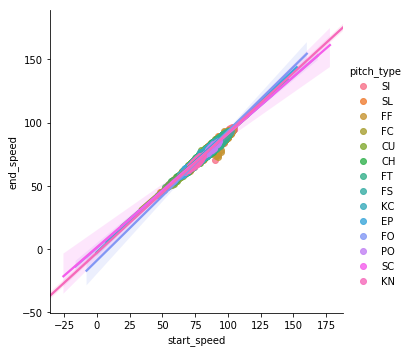

In [104]:
speed = df[['start_speed','end_speed','pitch_type']]
sns.lmplot(x='start_speed',y='end_speed',hue='pitch_type',data=speed)
plt.show()

Below is an interactive plot to zoom in on any pitch type of interest.

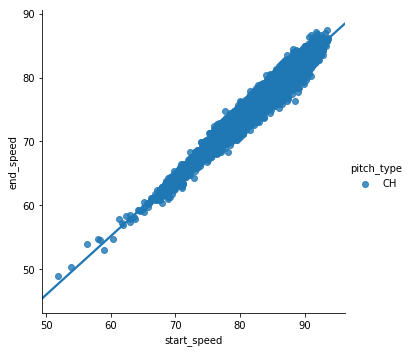

<function __main__.pitch(df, typ)>

In [93]:
def pitch(df,typ):
    speed = df.where(df['pitch_type']==typ)
    sns.lmplot(x='start_speed',y='end_speed',hue='pitch_type',data=speed)
interact(pitch,df=fixed(speed),typ=pitch_types)

- interested in seeing how speed drop will play a part in deception

In [84]:
pd.concat([df['start_speed'].describe(),df['end_speed'].describe()],axis=1)

start_speed      end_speed
count  727340.000000  727340.000000
mean       88.638227      81.280426
std         5.916455       5.243720
min        46.700000      42.800000
25%        84.500000      77.800000
50%        89.900000      82.400000
75%        93.200000      85.200000
max       105.000000      96.900000

## Pitch F/X

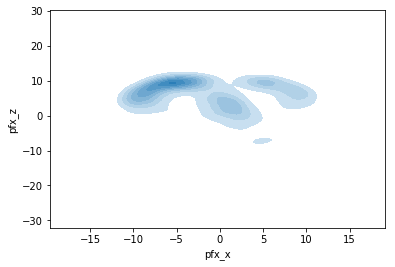

In [95]:
sns.kdeplot(df['pfx_x'].dropna(),df['pfx_z'].dropna(),shade=True,shade_lowest=False)
plt.show()

- need to figure out why there are these 3 really big group
- the **main focus** of my project will be on this spactial deception highlighted here

In [96]:
pd.concat([df['pfx_x'].describe(),df['pfx_z'].describe()],axis=1)

pfx_x          pfx_z
count  727329.000000  727329.000000
mean       -1.230963       4.679717
std         6.142452       5.063062
min       -18.316941     -31.052488
25%        -6.547735       1.761395
50%        -1.739940       5.748377
75%         3.606293       8.668226
max        17.779539      28.981066

## Break Length

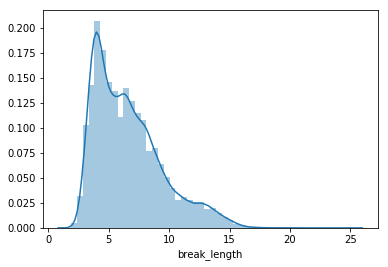

In [105]:
sns.distplot(df['break_length'].dropna())
plt.show()

- this will be another major component in my project seeing how this affects batting outcomes

In [106]:
df['break_length'].describe()

count    727329.000000
mean          6.623598
std           2.838064
min           1.400000
25%           4.300000
50%           6.100000
75%           8.200000
max          25.400000
Name: break_length, dtype: float64

## Break Angle

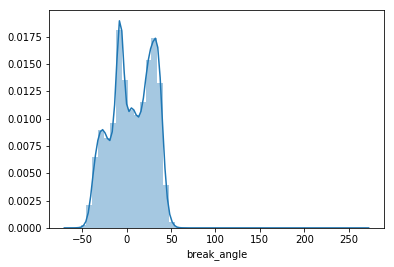

In [108]:
sns.distplot(df['break_angle'].dropna())
plt.show()

- what are the center points causing these humps?

In [110]:
df['break_angle'].describe()

count    727329.000000
mean          6.068450
std          23.277479
min         -65.200000
25%         -11.000000
50%           6.300000
75%          27.000000
max         267.500000
Name: break_angle, dtype: float64

## Break Y

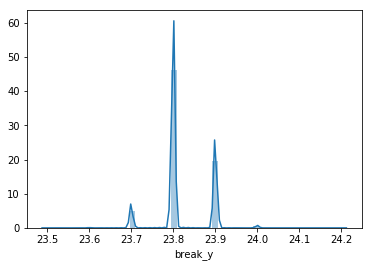

In [112]:
sns.distplot(df['break_y'].dropna())
plt.show()

In [113]:
df['break_y'].describe()

count    727329.000000
mean         23.821687
std           0.057563
min          23.500000
25%          23.800000
50%          23.800000
75%          23.900000
max          24.200000
Name: break_y, dtype: float64

## Outcomes of Pitch

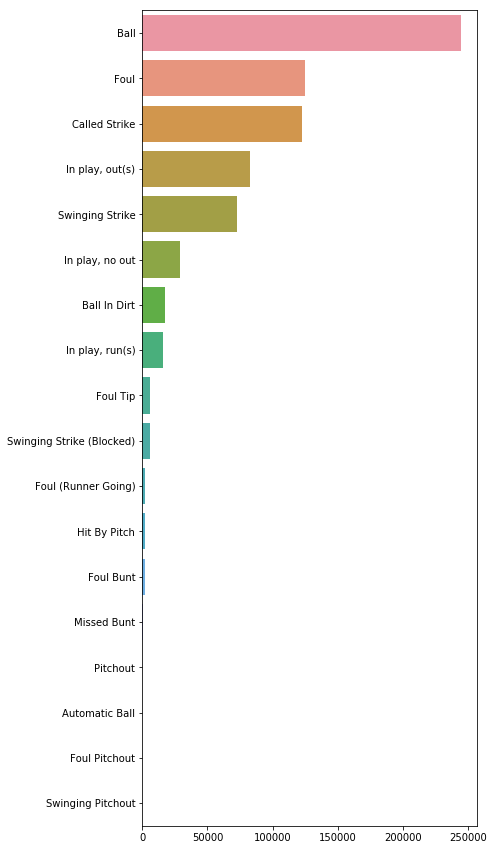

In [128]:
desc = df['des'].value_counts()
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(y=desc.index,x=desc.values)
plt.show()

# Other things to consider...
- time series to see how these things change over the course of the season
    - position shifts throughout the season